In [1]:
## Figure 9 - Filtering effect of network inversion on decorrelation noise
## comparison between observed interferometric phase and reconstructed phase from inverted time-series

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pysar.plot_network as pnet
from pysar.simulation.plot import *
from pysar.objects import sensor, ifgramStack
from pysar.utils import readfile, plot as pp, utils as ut

work_dir = os.path.expanduser('~/insarlab/PYSAR_EXAMPLE/SierraNegraAlosAT133/PYSAR')
work_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosAlosAT133/PYSAR/GEOCODE')
os.chdir(work_dir)
print('Go to diretory: '+work_dir)
proj_name = sensor.project_name2sensor_name(work_dir)[1]

## radar coord
#ifgram_file = './INPUTS/ifgramStack.h5'
#ts_file = 'timeseries.h5'
#water_mask_file = 'waterMask.h5'
#dem_file = './INPUTS/geometryRadar.h5'
# geo coord
ifgram_file = 'geo_ifgramStack.h5'
ts_file = 'geo_timeseries.h5'
water_mask_file = 'waterMask.h5'
dem_file = 'dem60m.h5'


date12 = '20070115_20110313'
m_date, s_date = date12.split('_')

obj = ifgramStack(ifgram_file) 
obj.open()
range2phase = -4. * np.pi / float(obj.metadata['WAVELENGTH'])
coord = ut.coordinate(obj.metadata)
geo_box = (-91.23, -0.74, -90.97, -0.99)         #(W, N, E, S)
proj_name = 'SierraNegraAlosAT133'
#box = (0, 0, obj.width, obj.length)
#box = (430, 0, 960, 640)
box = coord.box_geo2pixel(geo_box)

# read DEM
#dem = readfile.read(dem_file, datasetName='height', box=box)[0]
dem = readfile.read(dem_file, box=box)[0]

# read coherence
coh = readfile.read(ifgram_file, datasetName='coherence-{}'.format(date12), box=box)[0]
water_mask = readfile.read(water_mask_file, box=box)[0]
coh[water_mask==0] = 0.

# read interferometric phase
pha_orig = readfile.read(ifgram_file, datasetName='unwrapPhase-{}'.format(date12))[0]
pha_orig[pha_orig != 0] -= pha_orig[obj.refY, obj.refX]
pha_orig = pha_orig[box[1]:box[3], box[0]:box[2]]
pha_orig[pha_orig==0] = np.nan
pha_orig[water_mask==0] = np.nan
#pha_orig = ut.wrap(pha_orig)

# read reconstructed phase
pha_recon =  readfile.read(ts_file, datasetName=s_date, box=box)[0]
pha_recon -= readfile.read(ts_file, datasetName=m_date, box=box)[0]
pha_recon *= range2phase
pha_recon[pha_recon==0] = np.nan
pha_recon[water_mask==0] = np.nan
#pha_recon = ut.wrap(pha_recon)

pha_diff = pha_recon - pha_orig
print('Done.')

Go to diretory: /Users/yunjunz/insarlab/Galapagos/GalapagosAlosAT133/PYSAR/GEOCODE
open ifgramStack file: geo_ifgramStack.h5
Done.


saved to file SierraNegraAlosAT133_netInv_filter.png


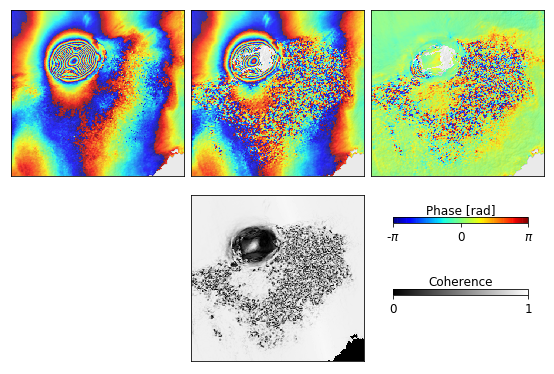

In [5]:
## Plot
inps = pp.cmd_line_parse()
inps.disp_dem_contour = False

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[7.5, 5])
for i, (ax, pha) in enumerate(zip([axs[0,0], axs[0,1], axs[0,2], axs[1,1]],
                                  np.array([pha_recon, pha_orig, pha_diff, coh]))):
    if i < 3:
        pp.plot_dem_background(ax=ax, geo_box=None, dem=dem, inps=inps, print_msg=False)
        im = ax.imshow(ut.wrap(pha), vmin=-np.pi, vmax=np.pi, cmap='jet', alpha=0.8)
    else:
        im2 = ax.imshow(coh, cmap='gray', vmin=0, vmax=1)
    # axis format
    pp.auto_flip_direction(obj.metadata, ax=ax, print_msg=False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
for ax in [axs[1,0], axs[1,2]]:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.axis('off')
plt.tight_layout(pad=0, h_pad=1)

## colorbar
cax1 = fig.add_axes([0.715, 0.20, 0.25, 0.015])
cax2 = fig.add_axes([0.715, 0.40, 0.25, 0.015])

cbar = plt.colorbar(im, cax=cax2, ticks=[-1.*np.pi, 0, np.pi], orientation='horizontal')
cbar.ax.set_xticklabels([r'-$\pi$','0', r'$\pi$'])
cbar.ax.tick_params(which='both', direction='out', labelsize=font_size)
cbar.set_label('Phase [rad]', fontsize=font_size)#, labelpad=-14)
cbar.ax.xaxis.set_label_position('top')

cbar2 = plt.colorbar(im2, cax=cax1, ticks=[0, 1], orientation='horizontal')
cbar2.ax.set_xticklabels(['0', '1'])
cbar2.ax.tick_params(which='both', direction='out', labelsize=font_size)
cbar2.set_label('Coherence', fontsize=font_size)
cbar2.ax.xaxis.set_label_position('top')

out_file = '{}_netInv_filter.png'.format(proj_name)
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file',out_file)
plt.show()

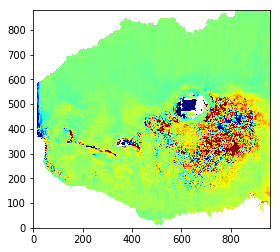

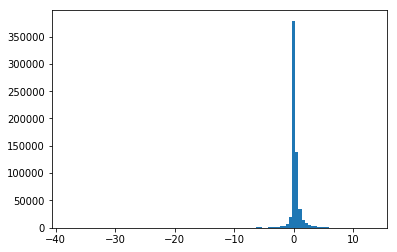

In [165]:
fig, ax = plt.subplots()
ax.imshow(pha_diff, cmap='jet', vmin=-np.pi, vmax=np.pi)
pp.auto_flip_direction(obj.metadata, ax=ax, print_msg=False)

plt.figure()
plt.hist(pha_diff[~np.isnan(pha_diff)].flatten(), bins=100)
plt.show()